In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 11 04:13:14 2025

@author: phemb
"""

import numpy as np

class Generateur_Donnees:

    v = 20
    g = 0.1
    f_v = 0.001

    def __init__(self, vitesse_initiale = v, pesanteur = g, frottement_visqueux = f_v):

        self._v_0 = vitesse_initiale
        self._g = pesanteur
        self._f_v = frottement_visqueux

    def position_virtuelle(self,t):

        return np.where(- 0.5*self._g*t**2 + self._v_0 *t >= 0,- 0.5*self._g*t**2 + self._v_0 *t,0)

    def position_reelle(self,t):

        A = self._v_0/self._f_v + self._g/(self._f_v**2)
        B = - A

        return np.where(A+B*np.exp(-self._f_v*t)-(self._g/self._f_v)*t >= 0,A+B*np.exp(-self._f_v*t)-(self._g/self._f_v)*t,0)

    def set_vitesse_initiale(self,vitesse):

        self._v_0 = vitesse

    def set_pesanteur(self,coefficient):

        self._g = coefficient

    def set_frottement_visqueux(self,coefficient):

        self._f_v = coefficient

In [41]:
# --- MAIN: ÉTAPE 1 (Analyse & Visualisation) ---

# 1. Instanciation et génération
gen = Generateur_Donnees()

# On génère un temps suffisamment long pour voir la chute complète
# v0=20, g=0.1 -> temps de vol approx 400s
t = np.linspace(0, 450, 1000)

pos_virtuelle = gen.position_virtuelle(t)
pos_reelle = gen.position_reelle(t)

# 2. Calcul de l'Ignorance (La cible pour notre futur IA)
# Ignorance = Ce qui manque au modèle virtuel pour être égal au réel
ignorance = pos_reelle - pos_virtuelle



In [42]:
import plotly.graph_objects as go

fig_traj = go.Figure()

fig_traj.add_trace(
    go.Scatter(
        x=t,
        y=pos_virtuelle,
        name="Virtuel (Simplifié)",
        line=dict(dash='dash', color='blue')
    )
)

fig_traj.add_trace(
    go.Scatter(
        x=t,
        y=pos_reelle,
        name="Réel (Avec Frottement)",
        line=dict(color='green')
    )
)

fig_traj.update_layout(
    title="Comparaison des Trajectoires",
    xaxis_title="Temps (s)",
    yaxis_title="Hauteur (m)",
    hovermode="x unified",
    height=500
)

fig_traj.show()


In [43]:
fig_err = go.Figure()

fig_err.add_trace(
    go.Scatter(
        x=t,
        y=ignorance,
        name="Ignorance (Erreur)",
        line=dict(color='red')
    )
)

fig_err.update_layout(
    title="Visualisation de l'Ignorance (Erreur de Modélisation)",
    xaxis_title="Temps (s)",
    yaxis_title="Delta (m)",
    hovermode="x unified",
    height=500
)

fig_err.show()


In [4]:
# Formatage pour Scikit-Learn (Matrice 2D obligatoire pour X)
X = t.reshape(-1, 1)
y = ignorance

# --- 2. DÉVELOPPEMENT MACHINE LEARNING ---

# Séparation Train / Test (80% entrainement, 20% test)
# On mélange (shuffle) pour que le modèle apprenne sur tout le domaine temporel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. APPRENTISSAGE MACHINE (Question 4) ---
# Choix du modèle : Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- 4. CRÉATION DU JUMEAU HYBRIDE ---
# On prédit l'ignorance sur tout le vecteur temps pour visualiser la courbe complète
ignorance_predite_totale = model.predict(X)

# FORMULE DU JUMEAU HYBRIDE : Physique + ML
pos_hybride = pos_virtuelle + ignorance_predite_totale

# --- 5. ÉVALUATION RAPIDE ---
score_r2 = r2_score(y, ignorance_predite_totale)
print(f"Précision du modèle d'ignorance (R²) : {score_r2:.4f} (1.0 = Parfait)")

# --- 6. VISUALISATION FINALE (Plotly) ---
fig = go.Figure()

# A. Le modèle physique (faux mais base solide)
fig.add_trace(go.Scatter(x=t, y=pos_virtuelle, name="Modèle Physique (Simplifié)",
                         line=dict(dash='dash', color='blue', width=2)))

# B. La réalité (ce qu'on veut atteindre)
fig.add_trace(go.Scatter(x=t, y=pos_reelle, name="Réalité (Target)",
                         line=dict(color='green', width=4), opacity=0.4))

# C. Le Jumeau Hybride (Physique + ML)
fig.add_trace(go.Scatter(x=t, y=pos_hybride, name="Jumeau Hybride (Physique + IA)",
                         line=dict(dash='dot', color='red', width=2)))

fig.update_layout(
    title="Jumeau Hybride vs Réalité",
    xaxis_title="Temps (s)",
    yaxis_title="Position (m)",
    hovermode="x unified"
)
fig.show()

Précision du modèle d'ignorance (R²) : 1.0000 (1.0 = Parfait)


In [20]:
# --- 2. CRÉATION DU "MEGA DATASET" (Question 5) ---
print("Génération du Dataset multi-paramètres en cours...")

X_list = []
y_list = []
gen = Generateur_Donnees()

# On crée 100 scénarios différents aléatoires
nb_scenarios = 500
t_base = np.linspace(0, 800, 800) # 100 points par courbe

for _ in range(nb_scenarios):
    # Paramètres aléatoires (Uniforme)
    v_rand = np.random.uniform(10, 50)   # Vitesse entre 10 et 50 m/s
    g_rand = np.random.uniform(0.05, 0.2) # Gravité variée
    f_rand = np.random.uniform(0.0005, 0.005) # Frottement varié

    # Mise à jour du générateur
    gen.set_vitesse_initiale(v_rand)
    gen.set_pesanteur(g_rand)
    gen.set_frottement_visqueux(f_rand)

    # Calcul des courbes
    pos_v = gen.position_virtuelle(t_base)
    pos_r = gen.position_reelle(t_base)
    ignorance = pos_r - pos_v

    # Stockage des données pour l'IA
    # Pour chaque instant t, l'IA doit connaitre le contexte (v, g, f)
    for i in range(len(t_base)):
        # Entrée : [Temps, Vitesse, Gravité, Frottement]
        X_list.append([t_base[i], v_rand, g_rand, f_rand])
        # Sortie : Ignorance correspondante
        y_list.append(ignorance[i])

X = np.array(X_list)
y = np.array(y_list)

print(f"Dataset créé : {len(X)} points d'entrainement.")


Génération du Dataset multi-paramètres en cours...
Dataset créé : 400000 points d'entrainement.


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# --- 3. APPRENTISSAGE ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Score de généralisation (R²) : {score:.4f}")



Score de généralisation (R²) : 1.0000


In [32]:
# --- 4. TEST SUR CAS INÉDIT (Avec Scaling) ---
test_v = 45.0
test_g = 0.12
test_f = 0.002

gen.set_vitesse_initiale(test_v)
gen.set_pesanteur(test_g)
gen.set_frottement_visqueux(test_f)

t_valid = np.linspace(0, 800, 800)
pos_v_valid = gen.position_virtuelle(t_valid)
pos_r_valid = gen.position_reelle(t_valid)

# Préparation des données de test (DOIVENT ÊTRE SCALÉES AUSSI !)
X_valid_raw = np.column_stack((
    t_valid,
    np.full_like(t_valid, test_v),
    np.full_like(t_valid, test_g),
    np.full_like(t_valid, test_f)
))
X_valid_scaled = scaler.transform(X_valid_raw) # On utilise le même scaler

ignorance_predite = model.predict(X_valid_scaled)
pos_hybride = pos_v_valid + ignorance_predite

In [33]:
# --- 5. VISUALISATION (CORRIGÉE) ---
fig = go.Figure()

# Virtuel
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_v_valid,
    name="Virtuel (Simplifié)",
    line=dict(dash='dash', color='blue')
))

# Réalité (Correction : opacity est sorti du dict 'line')
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_r_valid,
    name="Réalité (Inédite)",
    opacity=0.5,  # <--- CORRECTION ICI
    line=dict(color='green', width=4)
))

# Hybride
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_hybride,
    name="Hybride (Prédit)",
    line=dict(dash='dot', color='red')
))

title_str = f"Test Généralisation (v={test_v}, g={test_g}, f={test_f})"
fig.update_layout(title=title_str, xaxis_title="Temps", yaxis_title="Position", hovermode="x unified")
fig.show()

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# ... (Le code de génération de données reste le même) ...
# Assurez-vous d'avoir exécuté la partie génération (X et y) avant ce bloc

print("--- Début du nouvel entrainement (Optimisé) ---")

# 1. MISE À L'ÉCHELLE (SCALING) - CRUCIAL !
# Cela met t, v, g, f sur un pied d'égalité pour l'IA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. SÉPARATION
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. NOUVEAU MODÈLE : Gradient Boosting
# Souvent meilleur que le Random Forest pour la régression fine
model1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model1.fit(X_train, y_train)

score1 = model1.score(X_test, y_test)
print(f"Nouveau Score de généralisation (R²) : {score:.5f}")

# --- 4. TEST SUR CAS INÉDIT (Avec Scaling) ---
test_v = 45.0
test_g = 0.12
test_f = 0.002

gen.set_vitesse_initiale(test_v)
gen.set_pesanteur(test_g)
gen.set_frottement_visqueux(test_f)

t_valid = np.linspace(0, 800, 800)
pos_v_valid = gen.position_virtuelle(t_valid)
pos_r_valid = gen.position_reelle(t_valid)

# Préparation des données de test (DOIVENT ÊTRE SCALÉES AUSSI !)
X_valid_raw = np.column_stack((
    t_valid,
    np.full_like(t_valid, test_v),
    np.full_like(t_valid, test_g),
    np.full_like(t_valid, test_f)
))
X_valid_scaled = scaler.transform(X_valid_raw) # On utilise le même scaler

ignorance_predite = model1.predict(X_valid_scaled)
pos_hybride = pos_v_valid + ignorance_predite

# --- 5. VISUALISATION (CORRIGÉE) ---
fig = go.Figure()

# Virtuel
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_v_valid,
    name="Virtuel (Simplifié)",
    line=dict(dash='dash', color='blue')
))

# Réalité (Correction : opacity est sorti du dict 'line')
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_r_valid,
    name="Réalité (Inédite)",
    opacity=0.5,  # <--- CORRECTION ICI
    line=dict(color='green', width=4)
))

# Hybride
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_hybride,
    name="Hybride (Prédit)",
    line=dict(dash='dot', color='red')
))

title_str = f"Test Généralisation (v={test_v}, g={test_g}, f={test_f})"
fig.update_layout(title=title_str, xaxis_title="Temps", yaxis_title="Position", hovermode="x unified")
fig.show()

--- Début du nouvel entrainement (Optimisé) ---
Nouveau Score de généralisation (R²) : 0.99999


In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# --- 1. PRÉPARATION (SCALING OBLIGATOIRE POUR LES NEURONES) ---
# Les réseaux de neurones détestent quand 't' vaut 800 et 'f' vaut 0.001
# On ramène tout autour de 0.
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# On peut aussi scaler la cible y pour aider (optionnel mais recommandé si y est grand)
# Ici y (ignorance) peut être grand, donc on ne le scale pas forcément pour garder l'unité mètres,
# mais le modèle convergera plus vite si on le fait. Restons simple sur y pour l'instant.

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- 2. MODÈLE : RÉSEAU DE NEURONES (MLP) ---
print("Entraînement du Réseau de Neurones en cours... (peut prendre quelques secondes)")

# Architecture : 3 couches cachées de 64, 64 et 32 neurones
# Activation 'relu' est standard, 'tanh' est parfois plus lisse pour la physique. Essayons 'relu'.
model = MLPRegressor(
    hidden_layer_sizes=(64, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,        # Assez d'itérations pour converger
    random_state=42,
    early_stopping=True, # Arrête si ça ne s'améliore plus (évite le surapprentissage)
    n_iter_no_change=10
)

model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Score MLP (R²) : {score:.5f}")


Entraînement du Réseau de Neurones en cours... (peut prendre quelques secondes)
Score MLP (R²) : 0.99982


In [44]:

# --- 3. VALIDATION VISUELLE ---
# Paramètres de test
test_v = 45.0
test_g = 0.12
test_f = 0.002

gen.set_vitesse_initiale(test_v)
gen.set_pesanteur(test_g)
gen.set_frottement_visqueux(test_f)

t_valid = np.linspace(0, 800, 800)
pos_v_valid = gen.position_virtuelle(t_valid)
pos_r_valid = gen.position_reelle(t_valid)

# Prédiction
X_valid_raw = np.column_stack((
    t_valid,
    np.full_like(t_valid, test_v),
    np.full_like(t_valid, test_g),
    np.full_like(t_valid, test_f)
))
X_valid_scaled = scaler_X.transform(X_valid_raw) # Important : utiliser le même scaler !

ignorance_predite = model.predict(X_valid_scaled)
pos_hybride = pos_v_valid + ignorance_predite

# --- 5. VISUALISATION (CORRIGÉE) ---
fig = go.Figure()

# Virtuel
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_v_valid,
    name="Virtuel (Simplifié)",
    line=dict(dash='dash', color='blue')
))

# Réalité (Correction : opacity est sorti du dict 'line')
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_r_valid,
    name="Réalité (Inédite)",
    opacity=0.5,  # <--- CORRECTION ICI
    line=dict(color='green', width=4)
))

# Hybride
fig.add_trace(go.Scatter(
    x=t_valid,
    y=pos_hybride,
    name="Hybride (Prédit)",
    line=dict(dash='dot', color='red')
))

title_str = f"Test Généralisation (v={test_v}, g={test_g}, f={test_f})"
fig.update_layout(title=title_str, xaxis_title="Temps", yaxis_title="Position", hovermode="x unified")
fig.show()

--- Lancement du Benchmark Final ---
Test de : Régression Linéaire...
Test de : Random Forest...
Test de : Réseau de Neurones (MLP)...

--- RÉSULTATS À INCLURE DANS LE RAPPORT ---
                     Modèle  R2 Score    RMSE (m)  Temps Entrainement (s)  \
0       Régression Linéaire   0.43614  1575.40332                 0.04244   
1             Random Forest   0.99999     7.92504                81.68343   
2  Réseau de Neurones (MLP)   0.99982    27.86250                88.38154   

   Temps Prédiction (s)  
0               0.00107  
1               2.26891  
2               0.28633  


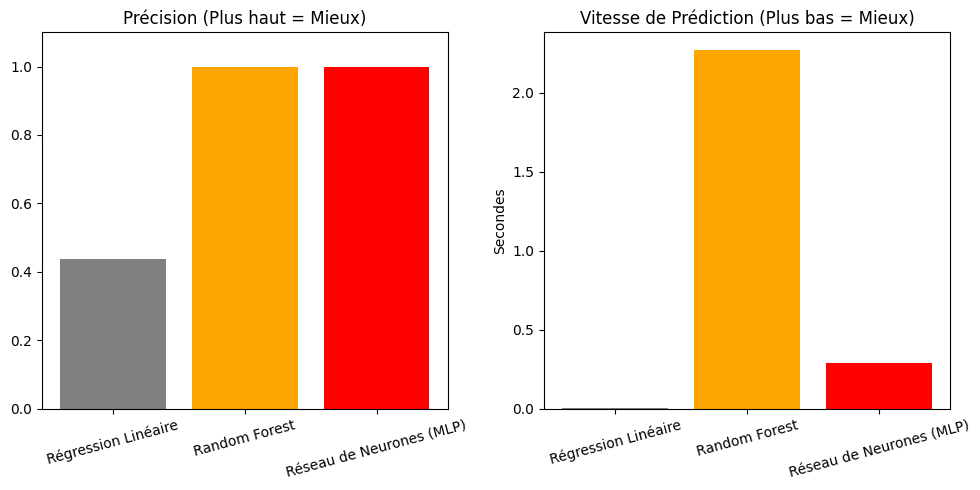

In [40]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- RÉCUPÉRATION DES DONNÉES ---
# On suppose que X et y sont toujours en mémoire depuis l'étape précédente.
# Si non, relancez la génération du "MEGA DATASET".

# 1. SCALING (Crucial pour que le Benchmark soit équitable pour le MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. LISTE DES COMBATTANTS
models = [
    ("Régression Linéaire", LinearRegression()),
    ("Random Forest", RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
    ("Réseau de Neurones (MLP)", MLPRegressor(hidden_layer_sizes=(64, 64, 32), activation='relu', max_iter=500, random_state=42,    early_stopping=True, n_iter_no_change=10))
]

results = []

print("--- Lancement du Benchmark Final ---")

for name, model in models:
    print(f"Test de : {name}...")

    # A. Temps d'apprentissage
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # B. Temps de prédiction
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    pred_time = end_pred - start_pred

    # C. Métriques
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        "Modèle": name,
        "R2 Score": r2,
        "RMSE (m)": rmse,
        "Temps Entrainement (s)": train_time,
        "Temps Prédiction (s)": pred_time
    })

# 3. AFFICHAGE TABLEAU
df_results = pd.DataFrame(results)
print("\n--- RÉSULTATS À INCLURE DANS LE RAPPORT ---")
print(df_results.round(5))

# 4. GRAPHIQUE FINAL
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(df_results["Modèle"], df_results["R2 Score"], color=['gray', 'orange', 'red'])
plt.title("Précision (Plus haut = Mieux)")
plt.ylim(0, 1.1)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
plt.bar(df_results["Modèle"], df_results["Temps Prédiction (s)"], color=['gray', 'orange', 'red'])
plt.title("Vitesse de Prédiction (Plus bas = Mieux)")
plt.ylabel("Secondes")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

In [45]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# --- 2. ENTRAÎNEMENT DES MODÈLES ---
print("Entraînement en cours...")
models = [
    ("Linéaire", LinearRegression()),
    ("Random Forest", RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)),
    ("MLP (Neurones)", MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))
]

trained_models = []
for name, model in models:
    model.fit(X_scaled, y)
    trained_models.append((name, model))

# --- 3. CONFIGURATIONS DE TEST (LIGNES) ---
configs = [
    {"v": 20, "g": 0.1, "f": 0.001, "name": "Config 1: Standard"},
    {"v": 45, "g": 0.15, "f": 0.003, "name": "Config 2: Extrême"},
    {"v": 15, "g": 0.05, "f": 0.0005, "name": "Config 3: Faible Gravité"}
]

# --- 4. CRÉATION DU SUBPLOTS PLOTLY ---
fig = make_subplots(
    rows=3, cols=3,
    shared_xaxes=False,
    vertical_spacing=0.1,
    subplot_titles=[f"{m[0]}<br>{c['name']}" for c in configs for m in trained_models]
    # Note: subplot_titles remplit ligne par ligne (Row1Col1, Row1Col2...)
)

t_plot = np.linspace(0, 800, 400)

# Boucle sur les Configurations (Lignes)
for i, conf in enumerate(configs):
    gen.set_vitesse_initiale(conf["v"])
    gen.set_pesanteur(conf["g"])
    gen.set_frottement_visqueux(conf["f"])

    pos_v = gen.position_virtuelle(t_plot)
    pos_r = gen.position_reelle(t_plot)

    # Boucle sur les Modèles (Colonnes)
    for j, (model_name, model) in enumerate(trained_models):

        # Prédiction
        X_val_raw = np.column_stack((
            t_plot,
            np.full_like(t_plot, conf["v"]),
            np.full_like(t_plot, conf["g"]),
            np.full_like(t_plot, conf["f"])
        ))
        X_val_scaled = scaler.transform(X_val_raw)

        ignorance_pred = model.predict(X_val_scaled)
        pos_hybride = pos_v + ignorance_pred

        # Calcul Métriques Locales
        r2 = r2_score(pos_r, pos_hybride)
        rmse = np.sqrt(mean_squared_error(pos_r, pos_hybride))

        # Ajout des traces
        # 1. Virtuel (Bleu pointillé) - Seulement ajouté une fois pour la légende si besoin, mais ici on répète pour clarté
        fig.add_trace(go.Scatter(x=t_plot, y=pos_v, mode='lines',
                                 line=dict(dash='dash', color='blue', width=1),
                                 name='Virtuel' if (i==0 and j==0) else None, showlegend=(i==0 and j==0)),
                      row=i+1, col=j+1)

        # 2. Réel (Vert épais)
        fig.add_trace(go.Scatter(x=t_plot, y=pos_r, mode='lines',
                                 line=dict(color='green', width=3), opacity=0.4,
                                 name='Réel' if (i==0 and j==0) else None, showlegend=(i==0 and j==0)),
                      row=i+1, col=j+1)

        # 3. Hybride (Rouge)
        fig.add_trace(go.Scatter(x=t_plot, y=pos_hybride, mode='lines',
                                 line=dict(color='red', width=2),
                                 name=f'Hybride ({model_name})' if (i==0 and j==0) else None, showlegend=(i==0 and j==0)),
                      row=i+1, col=j+1)

        # Annotation des métriques dans le graph
        fig.add_annotation(
            xref="x domain", yref="y domain",
            x=0.5, y=0.9,
            text=f"<b>R²={r2:.3f} | RMSE={rmse:.1f}m</b>",
            showarrow=False, font=dict(size=10, color="black"),
            row=i+1, col=j+1
        )

# Mise en forme finale
fig.update_layout(
    height=900, width=1200,
    title_text="Comparaison Multi-Modèles et Multi-Configs (Jumeau Numérique)",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

Entraînement en cours...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning:

Training interrupted by user.

